<a href="https://colab.research.google.com/github/RudCodera8/AnimeClassifier/blob/main/Anime_char_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# from IPython.display import Image
!pip install -q python-telegram-bot

## Import the Goodies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile, shutil
from math import floor
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cpu activated.


## Download the datasets from kaggle

In [ ]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading DBZ dataset")
!kaggle datasets download insaiyancvk/dragon-ball-z-dataset
print("Downloading AOT dataset")
!kaggle datasets download susilkessav/wwwkagglecomsusilkessavaot
print("Downloading One Piece dataset")
!kaggle datasets download vyshnavp/one-piece
print("Downloading Naruto dataset")
!kaggle datasets download abhijimenon/narutocharactersdataset

## Extact the datasets

In [ ]:
print("Extracting DBZ dataset")
with zipfile.ZipFile("/content/dragon-ball-z-dataset.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm dragon-ball-z-dataset.zip

print("Extracting AOT dataset")
with zipfile.ZipFile("/content/wwwkagglecomsusilkessavaot.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm wwwkagglecomsusilkessavaot.zip

print("Extracting One Piece dataset")
with zipfile.ZipFile("/content/one-piece.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm one-piece.zip '/content/One piece/One piece.csv'

print("Extracting Naruto dataset")
with zipfile.ZipFile("/content/narutocharactersdataset.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm narutocharactersdataset.zip

## Defining some constants and create some directories to save some useful information

In [ ]:
print("Initializing classes")

classes = []
for name in os.listdir('/content/AOT'):
  classes.append(name)
for name in os.listdir('/content/DBZ'):
  classes.append(name)
for name in os.listdir('/content/One piece'):
  classes.append(name)
for name in os.listdir('/content/naruto_character_dataset'):
  classes.append(name)

classes = [i.lower() for i in classes]
classes.sort()

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "animechar" : os.path.join(drive, "animechar"),
    "TRAIN": os.path.join("train"),
    "TEST": os.path.join("test"),
    "WORKSPACE": os.path.join(drive,"animechar","workspace"),
    "MODELS": os.path.join(drive,"animechar","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"animechar","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

In [9]:
# Create all classes directories in train and test dirs
for c in classes:
  if not os.path.isdir(FOLDERS['TRAIN']+'/'+c):
    os.mkdir(FOLDERS['TRAIN']+'/'+c)
for c in classes:
  if not os.path.isdir(FOLDERS['TEST']+'/'+c):
    os.mkdir(FOLDERS['TEST']+'/'+c)

In [12]:
len(os.listdir(FOLDERS['TRAIN'])) == len(os.listdir(FOLDERS['TEST']))

True

In [19]:
classes_dirs = {
    'Eren Yeager' : '/content/AOT/Eren Yeager',
    'Levi Ackerman': '/content/AOT/Levi Ackerman',
    'Reiner Braun' : '/content/AOT/Reiner Braun',
    'armin arlert' : '/content/AOT/armin arlert',
    'mikasa ackerman' : '/content/AOT/mikasa ackerman',
    'frieza' : '/content/DBZ/frieza',
    'muten roshi' : '/content/DBZ/muten roshi',
    'son gohan' : '/content/DBZ/son gohan',
    'son goku' : '/content/DBZ/son goku',
    'vegeta' : '/content/DBZ/vegeta',
    'chopper' : '/content/One piece/chopper',
    'luffy' : '/content/One piece/luffy',
    'sanji' : '/content/One piece/sanji',
    'usopp' : '/content/One piece/usopp',
    'zoro' : '/content/One piece/zoro',
    'itachi' : '/content/naruto_character_dataset/itachi',
    'kakashi' : '/content/naruto_character_dataset/kakashi',
    'naruto' : '/content/naruto_character_dataset/naruto',
    'sakura' : '/content/naruto_character_dataset/sakura',
    'sasuke' : '/content/naruto_character_dataset/sasuke'
}

## Split train and test data

In [28]:
def train_split(original_path, train_path):

  split = os.listdir(original_path)[:floor(len(os.listdir(original_path))*0.8)]
  for name in split:
    shutil.move(original_path+'/'+name, train_path)

def test_split(original_path, test_path):

  split = os.listdir(original_path)
  for name in split:
    shutil.move(original_path+'/'+name, test_path)

In [ ]:
for key in classes_dirs:
  print(f"Splitting {key} class")
  train_split(classes_dirs[key], FOLDERS['TRAIN']+'/'+key)
  test_split(classes_dirs[key], FOLDERS['TEST']+'/'+key)
  print(f'Split completed for {key}')

In [38]:
# Verify if they're actually split
train_len = len(os.listdir(FOLDERS['TRAIN']+'/itachi'))
test_len = len(os.listdir(FOLDERS['TEST']+'/itachi'))
train_len/(train_len+test_len)

0.8

In [39]:
# Delete the dataset folders
!rm -rf AOT DBZ One\ piece naruto_character_dataset

## Defining the transformations on train and test data

In [40]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

Defining the transformations for the speedy data


In [55]:
# Convert all classes to lower case
for name in os.listdir(FOLDERS['TRAIN']):
  os.rename(FOLDERS['TRAIN']+'/'+name, FOLDERS['TRAIN']+'/'+name.lower())
for name in os.listdir(FOLDERS['TEST']):
  os.rename(FOLDERS['TEST']+'/'+name, FOLDERS['TEST']+'/'+name.lower())

## Create the datasets for train and test 

In [60]:
print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


## Create Dataloader

In [61]:
BATCH =  32#@param {type:"integer"}

In [ ]:
# A useful library to oversample minority classes and undersample majority classes
pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [62]:
from torchsampler import ImbalancedDatasetSampler

print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        sampler = ImbalancedDatasetSampler(dataset["TRAIN"]),
        # shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        sampler = ImbalancedDatasetSampler(dataset["TEST"]),
        # shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


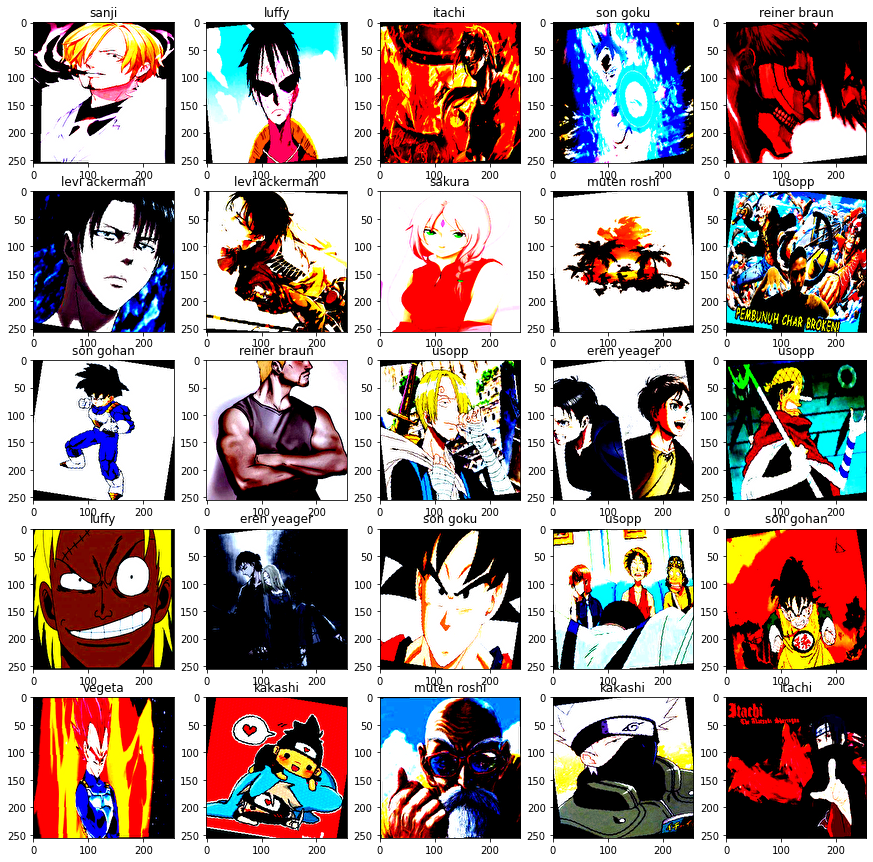

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [85]:
# Plot some training data
fig, axs = plt.subplots(5, 5, figsize=(15,15))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for image_list in (dataloader['TRAIN']):
            np_image=image_list[0][0]
            label_tensor=image_list[1][0]

            max_index = (label_tensor.item())
            label_emotion = classes[max_index]

            x=np_image.squeeze()
            x = np.transpose(x, (1,2,0))
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray');
            axs[j,i].title.set_text(label_emotion);
            break
plt.show()

## Training process begins

In [ ]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [ ]:
EPOCH =  15#@param {type:"integer"}

In [67]:
#@title Resnet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [77]:
NAME = f"ResNet50trial"
LR = 0.001

# model.load_state_dict(torch.load(f"/content/{FOLDERS['MODELS']}/{NAME}.pth"))

In [ ]:
done = False

model = model.to(device)

print(f"{NAME} INITIALIZED")
send().msg(f"{NAME} INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")

  vals = epoch(model, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")

      torch.save(model.state_dict(),model_name)

  fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
  a[0][0].plot(train_loss_vals)
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][1].plot(train_accuracy_vals)
  a[0][1].set_title("Train accuracy")
  a[0][1].grid(True)
  a[1][0].plot(test_loss_vals)
  a[1][0].set_title("Test loss")
  a[1][0].grid(True)
  a[1][1].plot(test_accuracy_vals)
  a[1][1].set_title("Test accuracy")
  a[1][1].grid(True)
  fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  
  if ep>2:
    performanceplot = f"PERFORMANCE.jpg"
    fig.savefig(performanceplot)

print(f"Total time taken to train for {EPOCH} epochs on {NAME}: {(time.time()-start)/60:.2f} min(s)")

print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch ",
      f"and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")

done = True

## Plot some predictions

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(14,14))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (dataloader["TEST"]):

            p_image=image_list[0][0]
            x=p_image.squeeze()

            x = x.swapaxes(0,1)
            x = x.swapaxes(1,2)
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray')

            with torch.no_grad():

              model.eval()
              p_image=p_image.cuda()
              lab=model(p_image.unsqueeze(0))
              lab=lab.cpu()
              max_index = np.argmax(lab[0]) 
              predicted_emotion = classes[max_index]
            
            axs[j,i].title.set_text(predicted_emotion)
            break

plt.show()

In [ ]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)